In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle (1).json to kaggle (1) (1).json


{'kaggle (1) (1).json': b'{"username":"swaradapathak","key":"0122cd4f102ccfde6a5847f9872440a2"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d puneet6060/intel-image-classification

100% 346M/346M [00:02<00:00, 146MB/s]
100% 346M/346M [00:02<00:00, 147MB/s]


In [ ]:
! unzip intel-image-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [ ]:
#Importing the neccessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils #dataset loading, model visualization
from tensorflow.keras.utils import model_to_dot #graphical representation of a Keras model as a Graphviz dot graph.
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Train

In [ ]:
#Reading images
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred', # labels from directory
    label_mode='int', #Encode labels as int [0,1...,6]
    class_names=None,
    color_mode='rgb',
    batch_size=32, #Default
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


In [ ]:
df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

Testing

In [ ]:
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


In [ ]:
df_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# getting class names of training data
class_names = df_train.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
# Dictionary comprehension
class_count = {class_name: 0 for class_name in class_names}
# initially assign 0 to each class name
class_count

{'buildings': 0,
 'forest': 0,
 'glacier': 0,
 'mountain': 0,
 'sea': 0,
 'street': 0}

In [ ]:

for _, labels in df_train: #_ : placeholder
  for label in labels.numpy(): # converts tensor into numpy and iterating over labels
    class_name = class_names[label]
    class_count[class_name] += 1

In [ ]:
for class_name, count in class_count.items():
  print(f"{class_name}: {count}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [ ]:
cls = pd.DataFrame(df_train.class_names).reset_index()
cls.rename(columns={'index': 'label', 0: 'class_name'}, inplace = True)
cls['class_name']=cls["class_name"].str.title()
cls['count']=class_count.values()
cls

,label,class_name,count
0,0,Buildings,2191
1,1,Forest,2271
2,2,Glacier,2404
3,3,Mountain,2512
4,4,Sea,2274
5,5,Street,2382


In [ ]:
#converting the dataset to a NumPy iterator which allows iterate over dataset
data_iterator = df_train.as_numpy_iterator()

In [ ]:
batch =data_iterator.next() #returns 2 things: batch[0]-> Images and batch[1]-> Labels

In [ ]:
for image_batch, labels_batch in df_train:
    print(image_batch.shape) # batch_size, image size, channels(rgb)
    print(labels_batch.shape) # batch size
    break

(32, 150, 150, 3)
(32,)


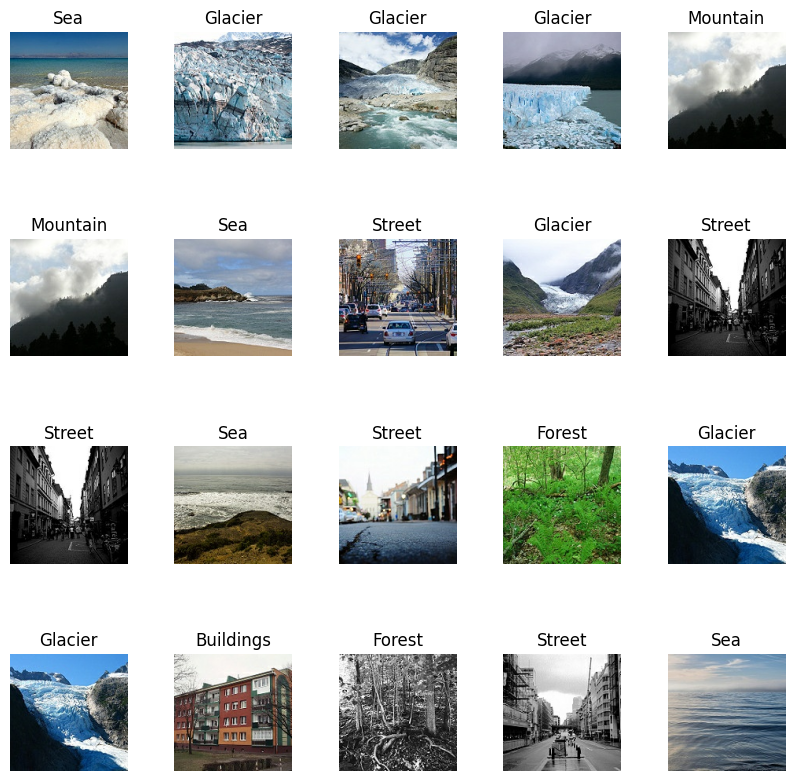

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10)) # creating subplot array
for i in range(4):
    for j in range(5):
        index = i * 4 + j
        ax[i, j].imshow(batch[0][index].astype(int)) # print images
        ax[i, j].set_title(cls["class_name"][batch[1][index]]) # print associated titles
        ax[i,j].axis('off') # no axis
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 max_pooling2d (MaxPooling2  (None, 29, 29, 200)       0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 168200)            0         
                                                                 
 dense (Dense)               (None, 180)               30276180  
                                                                 
 dense_1 (Dense)             (None, 6)                 1086      
                                                                 
Total params: 30282866 (115.52 MB)
Trainable params: 30282866 (115.52 MB)
Non-trainable params: 0 (0.00 Byte)
____________

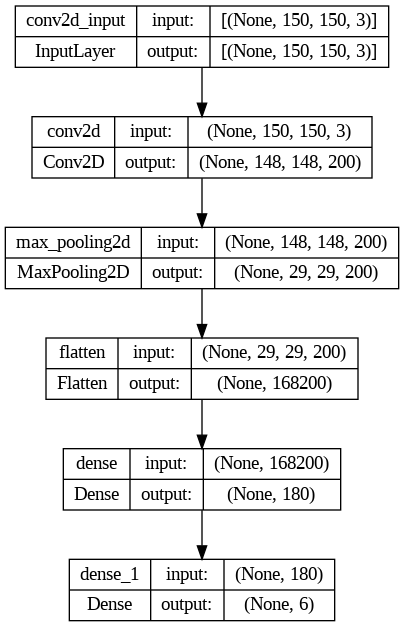

In [ ]:
model = Models.Sequential()

#Convolution
model.add(Layers.Conv2D(200, kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())

#ANN
model.add(Layers.Dense(180,activation='relu'))\

#O/P Layer 6 becuase - 6 classes
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer = Optimizer.Adam(lr = 0.0001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

In [ ]:
trained = model.fit(df_train, validation_data = df_test, epochs =10)

Epoch 1/10
439/439 [==============================] - 1017s 2s/step - loss: 76.6004 - accuracy: 0.4555 - val_loss: 1.3496 - val_accuracy: 0.5293
Epoch 2/10
439/439 [==============================] - 1037s 2s/step - loss: 0.8650 - accuracy: 0.6986 - val_loss: 1.3196 - val_accuracy: 0.5910
Epoch 3/10
439/439 [==============================] - 987s 2s/step - loss: 0.5065 - accuracy: 0.8273 - val_loss: 1.5416 - val_accuracy: 0.5927
Epoch 4/10
439/439 [==============================] - 982s 2s/step - loss: 0.3265 - accuracy: 0.8960 - val_loss: 2.0678 - val_accuracy: 0.5600
Epoch 5/10
294/439 [===================>..........] - ETA: 5:00 - loss: 0.2925 - accuracy: 0.9154